In [6]:
# basics
import numpy as np
import pandas as pd
import time

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler


In [7]:
# load data
def load_data(filename):
    with open(filename, 'r') as f:
        df = pd.read_csv(f)
        return df

In [8]:
def explore_data(df):
    
    print()
    print()
    print('EXPLORATORY DATA ANALYSIS')
    print()
    print()
    
    # Print the shape of the DataFrame.
    print(df.shape)

    # Print the names of the columns.
    print(df.columns)

    # Print the first 10 rows of the DataFrame.
    print(df.head(10))

    # Print the basic statistics of the DataFrame.
    print(df.describe())

    # histograms for all cols
    df.hist(bins=30, figsize=(20,15))
    plt.show()

    # correlation heatmap
    plt.figure(figsize=(16,12))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation heatmap')
    plt.show()

    # boxplots for all cols
    for column in df.select_dtypes(include=[np.number]).columns:
        plt.figure(figsize=(5,5))
        sns.boxplot(y=df[column])
        plt.title(f'Box plot of {column}')
        plt.show()

    # pair plot
    subset_of_columns = df.select_dtypes(include=[np.number]).columns[:4]  # Adjust this to include more columns
    sns.pairplot(df[subset_of_columns])
    plt.show()


In [9]:
from sklearn.preprocessing import StandardScaler

# train and evaluate a model
def train_and_evaluate_model(df, target_column):
    
    print()
    print()
    print('MODEL BUILD')
    print()
    print()
    
    # drop id
    df = df.drop(columns=['id'])

    # split into training and test
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target_column]), df[target_column], test_size=0.2, random_state=10)

    # scale both x and y on train set
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # scale both x and y on test set
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # track input dimension
    input_dim = X_train_scaled.shape[1]

    # create model
    model = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1)
    )

    # define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # convert pandas df to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float).view(-1, 1)

    # train model
    for epoch in range(1000):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        loss = loss_fn(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()

    # evaluate model
    model.eval()
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float).view(-1, 1)
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        loss = loss_fn(y_pred, y_test_tensor)
        print(f'Test Loss: {loss.item()}')

    return model, scaler_X, scaler_y



EXPLORATORY DATA ANALYSIS


(15289, 18)
Index(['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')
   id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0   0       25.0      0.50     0.25     0.75   0.50              69.7   
1   1       25.0      0.50     0.25     0.50   0.50              69.7   
2   2       12.5      0.25     0.25     0.63   0.63              86.0   
3   3       12.5      0.25     0.25     0.63   0.50              77.4   
4   4       25.0      0.50     0.25     0.63   0.63              77.4   
5   5       25.0      0.50     0.25     0.63   0.75              94.6   
6   6       12.5      0.25     0.38     0.50   0.63              86.0   
7   7       12.5      0.25     0.25     0.75  

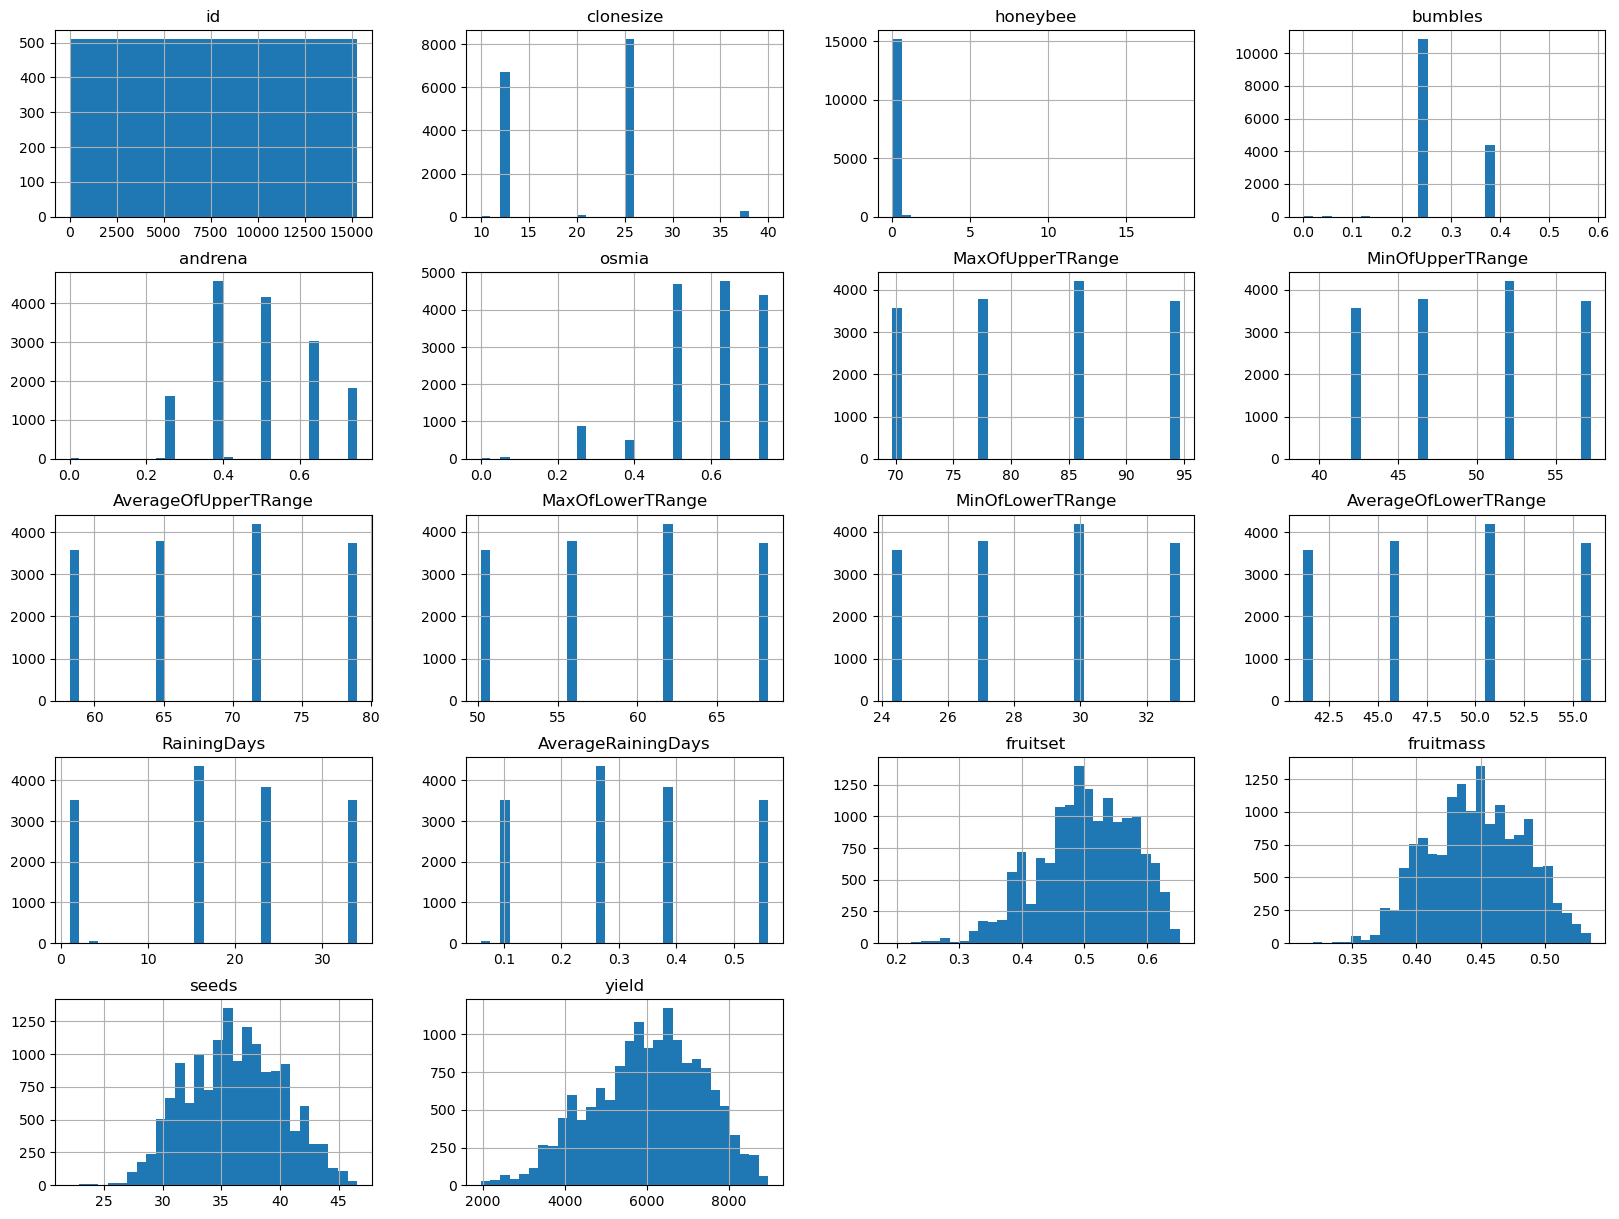

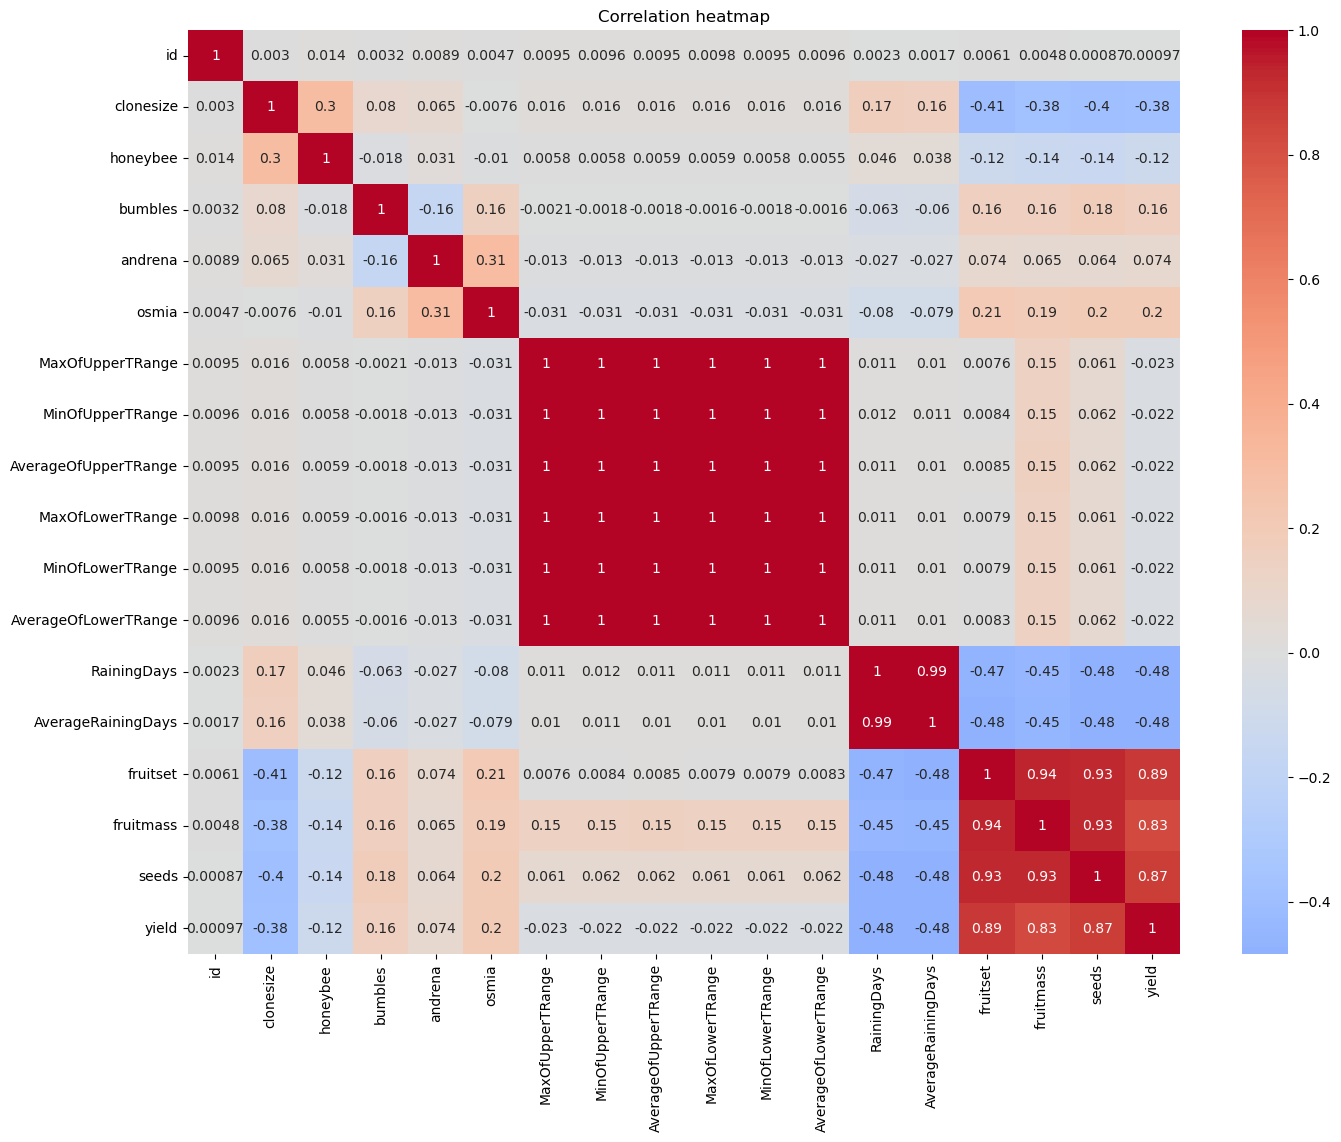

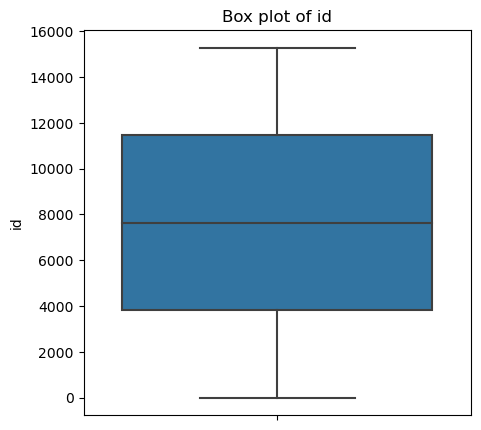

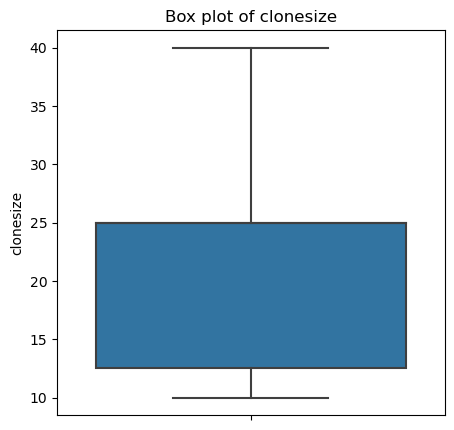

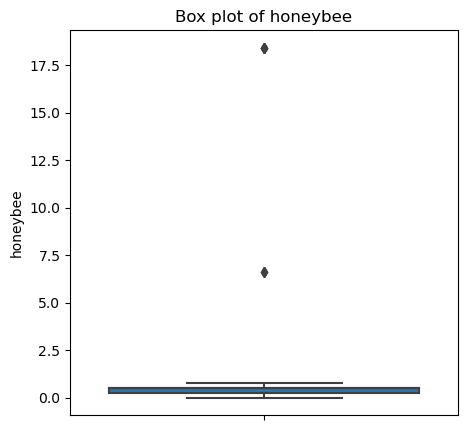

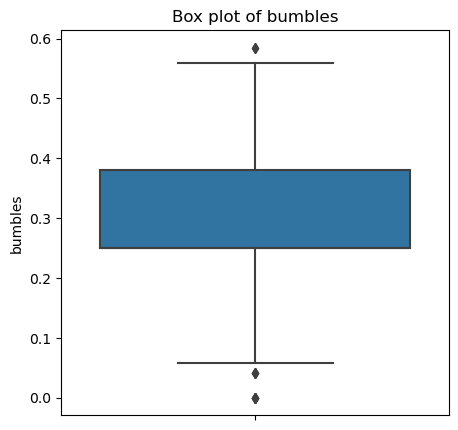

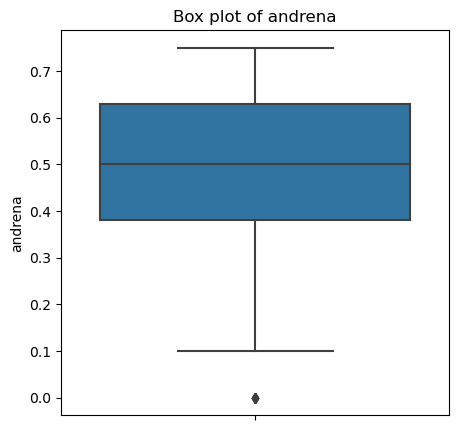

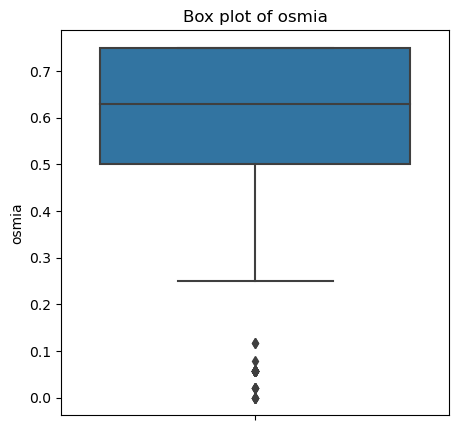

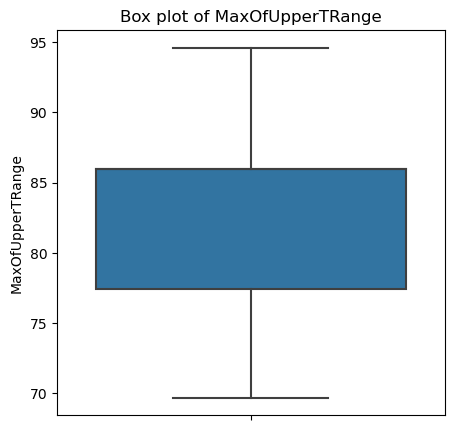

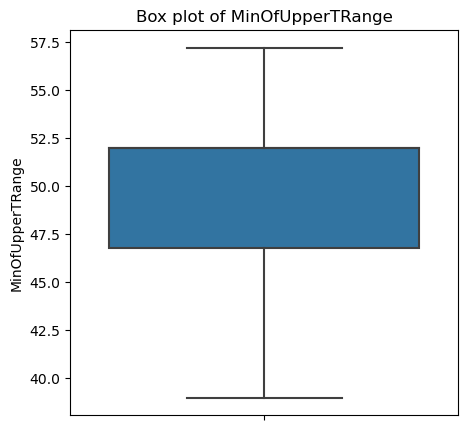

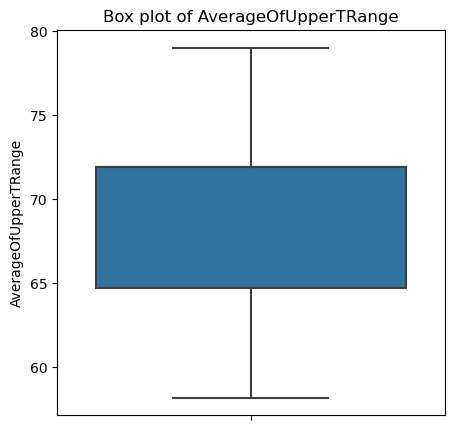

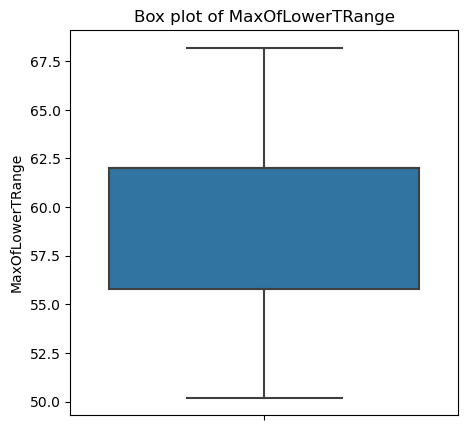

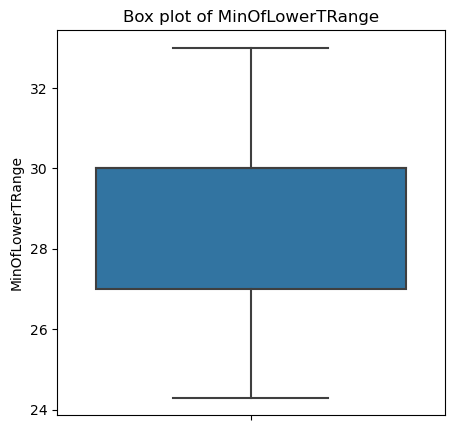

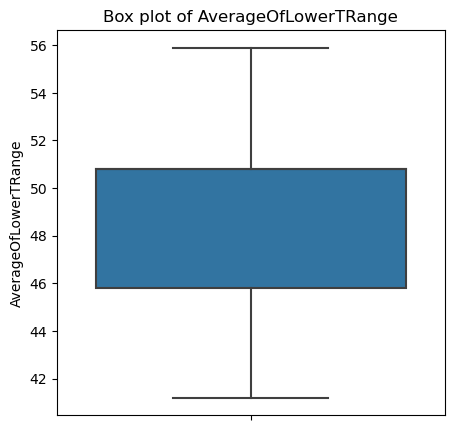

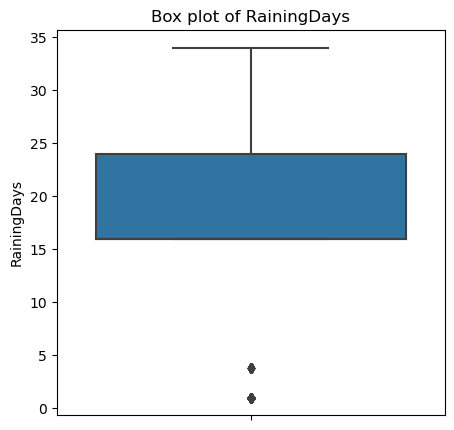

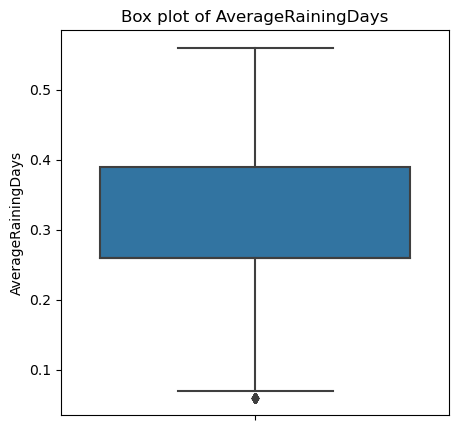

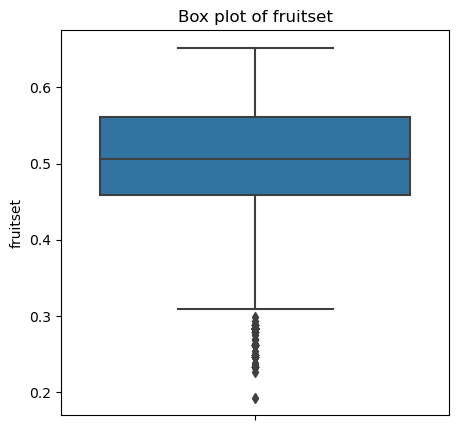

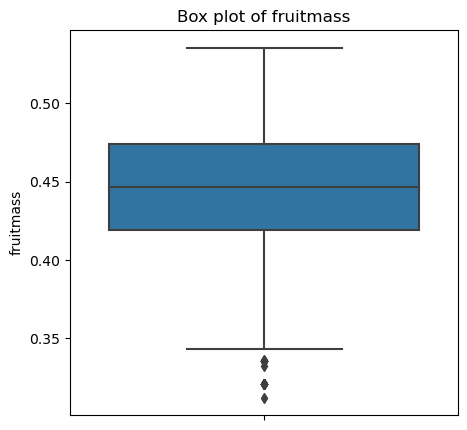

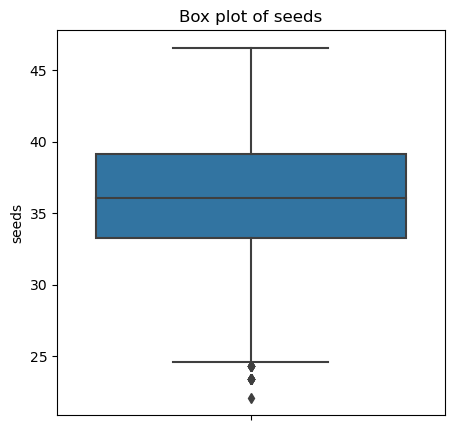

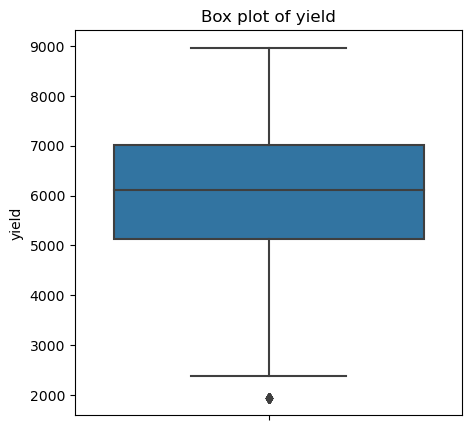

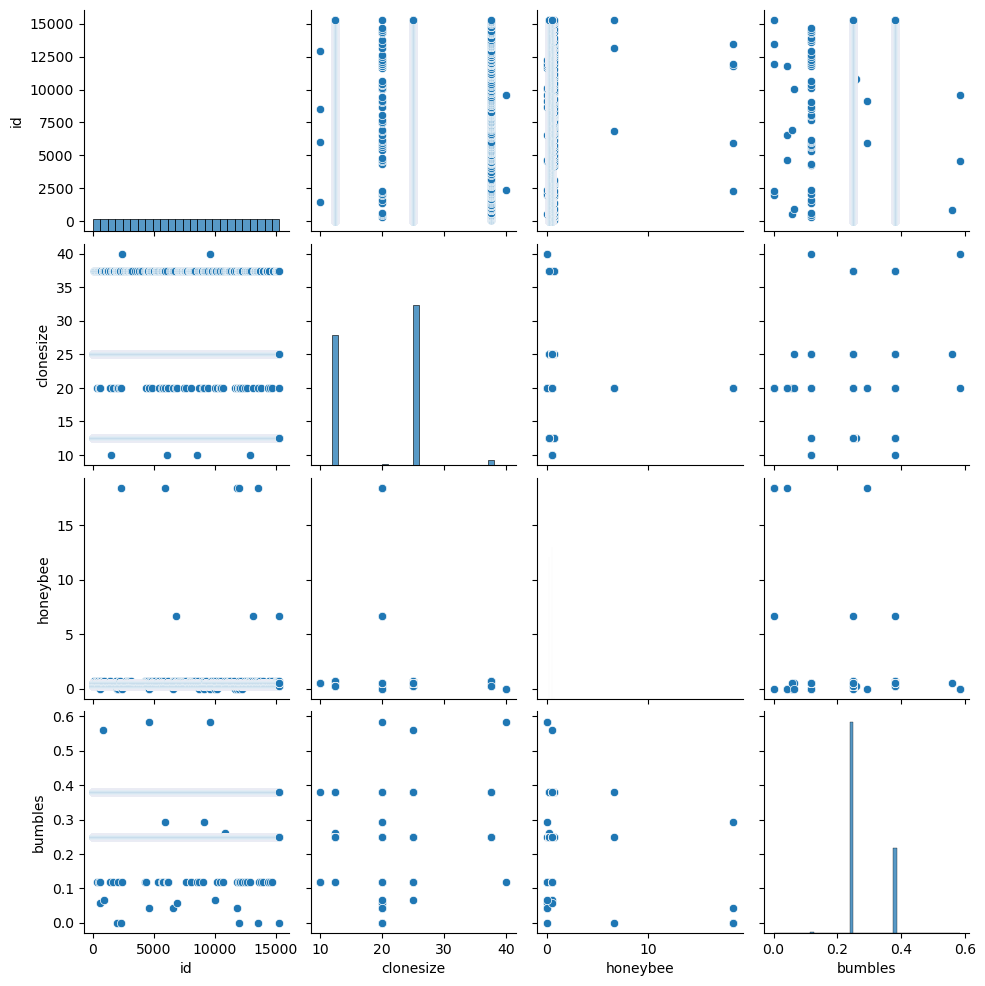



MODEL BUILD


Test Loss: 0.1814417541027069


In [10]:
def main():
    # load data
    training_data = load_data('train.csv')
    test_data = load_data('test.csv')

    # perform EDA
    explore_data(training_data)

    # train and evaluate model
    model, scaler_X, scaler_y = train_and_evaluate_model(training_data, 'yield')

    # make predictions on test set
    X_test_scaled = scaler_X.transform(test_data.drop(columns=['id']))
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
    with torch.no_grad():
        pred_test = model(X_test_tensor)

    # un-scale the predictions
    pred_test = scaler_y.inverse_transform(pred_test.numpy())

    # save submission file
    df_sub = pd.DataFrame({'Id': test_data['id'], 'yield': pred_test.flatten()})
    df_sub.to_csv('submission.csv', index=False)

if __name__ == '__main__':
    main()
